# Setup

## Imports

In [1]:
# Import importlib to reload modules and sys and os to add the path for other imports
import importlib
import sys
import os
import torch

# Append the parent directory to the path to import the necessary modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import the utilities and the dataloader
from utils import trainutil, inferutil, setuputil

# Now reload the modules to ensure they are up-to-date
importlib.reload(setuputil)
importlib.reload(trainutil)
importlib.reload(inferutil)

# Import the funcs needed from utils
from utils.setuputil import setup_config, display_config
from utils.trainutil import train_model
from utils.inferutil import infer_one, infer_full


## Configuration

In [2]:
# Define the input config file
input_config = {
    # Environment and Model Info
    "env": "gcp",                
    "approach": "bert",         
    "model_name": "TestBert",     
    "model_base": "prajjwal1/bert-tiny",  
    
    # System Configuration
    "device": "cuda:0",
    "threads": 14,
    "seed": 42,
    
    # Data Configuration
    "data_dir": "../../data/farzan",
    "data_ds": "manual",
    
    # Model Parameters
    "rows": 100,
    "cols": 100,
    "tokens": 32,
    
    # Training Parameters
    "batch": 2,
    "lr": 1e-4,
    "mu": 0.25,
    "epochs": 3,
    "patience": 2,
    "save_int": 0,
    "save_dir": '../models/'
}
config = setup_config(input_config)
display_config(config)

Processing files: 100%|██████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.28it/s]



40(P) = 40(G) + 0(E)


Processing files: 100%|██████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 4779.29it/s]



5(P) = 5(G) + 0(E)


Processing files: 100%|██████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 6472.69it/s]



5(P) = 5(G) + 0(E)

Configuration for BERT approach:
{
  "env": "gcp",
  "approach": "bert",
  "model_base": "prajjwal1/bert-tiny",
  "model_name": "TestBert",
  "rows": 100,
  "cols": 100,
  "tokens": 32,
  "DEVICE": "cuda:0",
  "THREADS": 14,
  "seed": 42,
  "data_ds": "manual",
  "data_dir": "../../data/farzan",
  "train_dir": "../../data/farzan/manual_train",
  "val_dir": "../../data/farzan/manual_val",
  "test_dir": "../../data/farzan/manual_test",
  "tokenizer": "<BERT Tokenizer Object>",
  "train_loader": "<LoaderBert Object>",
  "val_loader": "<LoaderBert Object>",
  "test_loader": "<LoaderBert Object>",
  "batch": 2,
  "lr": 0.0001,
  "mu": 0.25,
  "epochs": 3,
  "patience": 2,
  "save_int": 0,
  "save_dir": "../models/",
  "save_name": "gber42_TestBert_manual_100x100x32_bsz2lr1e-4ep3pa2"
}


In [3]:
# Define local variables from the config dictionary
DEVICE = config["DEVICE"]
THREADS = config["THREADS"]
gber42_TinyBert_manual_100x100x32
# Data loaders and vocab
train_loader = config["train_loader"]
val_loader = config["val_loader"]
test_loader = config["test_loader"]
tokenizer = config["tokenizer"]
model_base = config['model_base']

# Training parameters
batch_size = config["batch"]
lr = config["lr"]
mu = config["mu"]
epochs = config["epochs"]
patience = config["patience"]
save_int = config["save_int"]
save_dir = config["save_dir"]
save_name = config["save_name"]

## Checker Code for Loader Content

In [4]:
# # Check
# # Retrieve the first item's data from train_loader
# first_item = train_loader[0]

# # Extract tensors and file path
# x_tok = first_item['x_tok']
# x_masks = first_item['x_masks']
# y_tok = first_item['y_tok']
# file_path = first_item['file_paths']

# # Print the file path first
# print("File path:", file_path)

# # Print the shapes of the tensors
# print("Shape of x_tok:", x_tok.shape)
# print("Shape of x_masks:", x_masks.shape)
# print("Shape of y_tok:", y_tok.shape)

# # Define cell location
# row = 3
# col = 5

# # Extract data for the specific cell at (row, col)
# xtok_cell = x_tok[row, col, :]  # Tokenized input IDs for the cell
# xmask_cell = x_masks[row, col, :] if x_masks.numel() > 0 else None  # Attention mask for the cell (if applicable)
# ytok_cell = y_tok[row, col, :]  # Metadata tensor for the cell


# # Print extracted cell data
# print(f"\nx_tok at cell ({row}, {col}):\n", xtok_cell.tolist())
# if xmask_cell is not None:
#     print(f"\nx_masks at cell ({row}, {col}):\n", xmask_cell.tolist())
# print(f"\ny_tok at cell ({row}, {col}):\n", ytok_cell.tolist())

# # Decode x_tok of the cell into a list of words using the tokenizer
# decoded_words = tokenizer.decode(xtok_cell.tolist(), skip_special_tokens=False).split()
# print(f"\nDecoded words at cell ({row}, {col}):\n", decoded_words)


# Model Creation

In [5]:
# # Imports
# import torch
# import torch.nn as nn
# from transformers import AutoModel
# from tqdm import tqdm

# # Test model using tinybert for us
# class BertTiny(nn.Module):
#     def __init__(self, model_base="prajjwal1/bert-tiny", dropout_rate=0.05):
#         super(BertTiny, self).__init__()

#         # 1. Load pretrained BERT
#         self.bert = AutoModel.from_pretrained(model_base)

#         # 2. Define a dropout
#         self.dropout = nn.Dropout(dropout_rate)

#         # 3. Non-linear activation (GELU)
#         self.gelu = nn.GELU()

#         # 4. Final predictor (1-dim output per cell)
#         self.classifier = nn.Linear(self.bert.config.hidden_size, 1)

#     def forward(self, input_ids, attention_mask):

#         # 1. Print the overall shapes
#         # print("batch_size:", input_ids.shape[0])
#         # print("rows:",      input_ids.shape[1])
#         # print("cols:",      input_ids.shape[2])
#         # print("tokens:",    input_ids.shape[3])

#         # 2. Initialize S_cube => (batch_size, rows, cols)
#         S_cube = torch.zeros(
#             (input_ids.shape[0], input_ids.shape[1], input_ids.shape[2]),
#             device=input_ids.device
#         )

#         # 3. Loop over all cells
#         for cell in tqdm(range(input_ids.shape[1] * input_ids.shape[2]), desc = 'Forward'):

#             r = cell // input_ids.shape[2]
#             c = cell %  input_ids.shape[2]

#             # Extract the slice for current cell (batch_size x tokens)
#             cell_input_ids  = input_ids[:, r, c, :]
#             cell_attn_mask  = attention_mask[:, r, c, :]

#             # Pass them through the BERT model
#             outputs = self.bert(cell_input_ids, attention_mask=cell_attn_mask)

#             # pooler_out => (batch_size, hidden_dim)
#             pooler_out = outputs.pooler_output

#             # Inlined pipeline: dropout -> GELU -> classifier => (batch_size, 1)
#             logits = self.classifier(self.gelu(self.dropout(pooler_out)))

#             # Flatten (batch_size, 1) => (batch_size,)
#             logits_flat = logits.view(-1)

#             # Populate S_cube => shape: (batch_size, rows, cols)
#             S_cube[:, r, c] = logits_flat

#             # If this is the first cell, do some prints and break
#             # if r == 0 and c == 0:
#             #     print(f"\nFirst cell => row={r}, col={c}")
#             #     print(f"cell_input_ids.shape: {cell_input_ids.shape}")
#             #     print(f"cell_attn_mask.shape: {cell_attn_mask.shape}")
#             #     print(f"logits.shape: {logits.shape}")
#             #     print(f"logits_flat.shape: {logits_flat.shape}")
#             #     print(f"S_cube[:, {r}, {c}].shape: {S_cube[:, r, c].shape}")

#                 #break  # Stop after the first cell

#         # 4. Print the shape of S_cube
#         # print(f"\nS_cube.shape: {S_cube.shape}")

#         # Return S_cube or None, depending on your use case
#         return S_cube

    


In [6]:
import torch
import torch.nn as nn
from transformers import AutoModel
from tqdm import tqdm


class BertTiny(nn.Module):
    def __init__(self, model_base="bert-base-cased", dropout_rate=0.05):
        super(BertTiny, self).__init__()

        # 1. Load pretrained BERT
        self.bert = AutoModel.from_pretrained(model_base)

        # 2. Define a dropout
        self.dropout = nn.Dropout(dropout_rate)

        # 3. Non-linear activation (GELU)
        self.gelu = nn.GELU()

        # 4. Final predictor (1-dim output per cell)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):

        # 1) Allocate the (batch_size, rows, cols) S_cube
        S_cube = torch.zeros(
            (input_ids.shape[0], input_ids.shape[1], input_ids.shape[2]),
            device=input_ids.device,
        )

        # 2) Loop over cells in row-major order
        for cell in range(input_ids.shape[1] * input_ids.shape[2]):

            # In one shot, store logits → S_cube
            # cell // input_ids.shape[2] = row, cell % input_ids.shape[2] = col
            S_cube[
                :, cell // input_ids.shape[2], cell % input_ids.shape[2]
            ] = self.classifier(
                self.gelu(
                    self.dropout(
                        self.bert(
                            input_ids[
                                :,
                                cell // input_ids.shape[2],
                                cell % input_ids.shape[2],
                                :,
                            ],
                            attention_mask=attention_mask[
                                :,
                                cell // input_ids.shape[2],
                                cell % input_ids.shape[2],
                                :,
                            ],
                        ).pooler_output
                    )
                )
            ).view(
                -1
            )

        return S_cube

In [7]:
# 1) Create model and move to GPU Observe its architecture
untrained_model = BertTiny(model_base=model_base).to(DEVICE)
print(untrained_model)

BertTiny(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine

In [8]:
# # 2) Single-batch DataLoader
# check_loader = torch.utils.data.DataLoader(train_loader, batch_size=2, shuffle=False)
# batch = next(iter(check_loader))

# ex_xtok = batch["x_tok"].to(DEVICE)
# ex_xmask = batch["x_masks"].to(DEVICE)

# # Forward pass for a single batch
# output = untrained_model(input_ids=ex_xtok, attention_mask=ex_xmask)

# # Print the output shape
# print("Output shape (S_cube):", output.shape)


In [9]:
# Imports
import os  # For file and directory operations
import time  # For generating the timestamp in filenames
import torch  # Core PyTorch library
import torch.nn as nn  # For defining loss functions
import math  # For calculating exponential in perplexity calculation
from tqdm import tqdm  # For progress bars in training and validation loops
import sys
from sklearn.metrics import precision_score, recall_score, f1_score


# ------------------------------------------------------------------------
# Define a new function to train the BertTiny model using attention masks
def train_bert(model, train_data, val_data, DEVICE, batch_size=8, lr=1.4e-5, mu=0.25, max_epochs=4, patience=3, save_int=2, save_dir='../models/', save_name='bert_', config=None):
    
    # --------------------------------------------------------------------
    # Everything remains the same up until we get to the forward pass. 
    # We still set up logging, create train_loader, val_loader, define loss, etc.
    # --------------------------------------------------------------------
    
    # Set the option in torch to print full tensor
    torch.set_printoptions(profile="full")
    
    # Check if save_int > 0 and save_dir exists
    if save_int > 0 and not os.path.exists(save_dir):
        raise ValueError(f"Directory '{save_dir}' DNE")
    
    # Generate timestamp for naming checkpoints and logs
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    
    # Construct checkpoint paths
    model_path = os.path.join(save_dir, f"{save_name}_{timestamp}.pth")
    log_file = os.path.join(save_dir, f"{save_name}_{timestamp}.txt")
    
    # Write config to log if provided (and remove non-serializable items)
    if config is not None and save_int > 0:
        import json
        import copy
        
        config_serializable = copy.deepcopy(config)
        del config_serializable["DEVICE"]
        del config_serializable["train_loader"]
        del config_serializable["val_loader"]
        del config_serializable["test_loader"]
        
        with open(log_file, 'w') as log:
            log.write("\nFinal configuration:\n")
            log.write(json.dumps(config_serializable, indent=2))
            log.write("\n\n" + "="*80 + "\n\n")
    
    # --------------------------------------------------------------------
    # Create optimizer as before
    opt = torch.optim.Adagrad(model.parameters(), lr=lr)
    
    # Create the DataLoader for train and validation sets
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
    
    # Calculate class imbalance as before
    num_bold_cells = sum((batch['y_tok'][:, :, :, 6] == 1).sum() for batch in train_loader)
    num_nonbold_cells = sum((batch['y_tok'][:, :, :, 6] == 0).sum() for batch in train_loader)
    class_imbalance = num_nonbold_cells / num_bold_cells
    
    # Binary cross-entropy loss with logits
    loss_fn = nn.BCEWithLogitsLoss(
        pos_weight=torch.tensor([class_imbalance], dtype=torch.float).to(DEVICE)
    )
    
    # Initialize training parameters
    epoch = 0
    best_avgtrloss = float('inf')
    best_perp = float('inf')
    best_epoch = 0
    best_avgvalloss = float('inf')
    best_valperp = float('inf')
    nimp_ctr = 0
    training = True
    
    # --------------------------------------------------------------------
    # Main training loop
    # --------------------------------------------------------------------
    while training and (epoch < max_epochs):
        
        print(f'Epoch {epoch}')
        if save_int > 0:
            with open(log_file, 'a') as log:
                log.write(f"\nEpoch {epoch}\n")
        
        curr_trloss, curr_valloss = 0, 0
        
        # Put model in train mode
        model.train()
        
        # ----------------------------------------------------------------
        # Train step
        # ----------------------------------------------------------------
        for i, batch in enumerate(tqdm(train_loader, desc='Batch Processing')):
            
            # Zero out gradients
            model.zero_grad()
            
            # ----------------------------------------------------------------
            # CHANGED LINE: Now pass both input_ids and attention_mask to model
            logits = model(
                batch['x_tok'].to(DEVICE),
                batch['x_masks'].to(DEVICE)   # <--- Pass attention_mask here
            ).view(-1)
            
            # ----------------------------------------------------------------
            # Same as original: define labels
            labels = batch['y_tok'][:, :, :, 6].to(DEVICE).view(-1).float()
            
            # Compute loss
            loss = loss_fn(logits, labels)
            
            # Accumulate training loss
            curr_trloss += loss.detach().cpu().item()
            
            # Backprop
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=mu)
            
            # Update model parameters
            opt.step()
            
            # Clear memory
            del loss
        
        # Put model in eval mode
        model.eval()
        
        # ----------------------------------------------------------------
        # Validation step
        # ----------------------------------------------------------------
        for i, batch in enumerate(tqdm(val_loader, desc='Validation Processing')):
            with torch.no_grad():
                
                # ----------------------------------------------------------------
                # CHANGED LINE: Pass both input_ids and attention_mask to model
                val_logits = model(
                    batch['x_tok'].to(DEVICE),
                    batch['x_masks'].to(DEVICE)  # <--- Pass attention_mask here
                ).view(-1)
                
                # Labels remain the same
                val_labels = batch['y_tok'][:, :, :, 6].to(DEVICE).view(-1).float()
                
                # Compute validation loss
                val_loss = loss_fn(val_logits, val_labels)
                
                curr_valloss += val_loss.detach().cpu().item()
        
        # ----------------------------------------------------------------
        # Same perplexity calculations as original
        # ----------------------------------------------------------------
        curr_avgtrloss = curr_trloss / len(train_loader)
        curr_perp = math.exp(curr_trloss / (len(train_loader) * batch_size * 2500))
        curr_avgvalloss = curr_valloss / len(val_loader)
        curr_valperp = math.exp(curr_valloss / (len(val_loader) * batch_size * 2500))
        
        # Print stats
        print(f'Train Loss: {curr_avgtrloss}, Perplexity: {curr_perp}')
        print(f'Val Loss: {curr_avgvalloss}, Perplexity: {curr_valperp}\n')
        if save_int > 0:
            with open(log_file, 'a') as log:
                log.write(f'Train Loss: {curr_avgtrloss}, Perplexity: {curr_perp}\n')
                log.write(f'Val Loss: {curr_avgvalloss}, Perplexity: {curr_valperp}\n')
        
        # Early stopping checks
        if curr_valperp < best_valperp:
            best_perp = curr_perp
            best_valperp = curr_valperp
            best_avgtrloss = curr_avgtrloss
            best_avgvalloss = curr_avgvalloss
            best_epoch = epoch
            nimp_ctr = 0
        else:
            nimp_ctr += 1
        
        if nimp_ctr >= patience:
            print(f'\nEARLY STOPPING at epoch {epoch}, best epoch {best_epoch}')
            print(f'Train Loss = {best_avgtrloss}, Perplexity = {best_perp}')
            print(f'Val Loss = {best_avgvalloss}, Perplexity = {best_valperp}')
            if save_int > 0:
                with open(log_file, 'a') as log:
                    log.write(f'\nEARLY STOPPING at epoch {epoch}, best epoch {best_epoch}\n')
                    log.write(f'Train Loss = {best_avgtrloss}, Perplexity = {best_perp}\n')
                    log.write(f'Val Loss = {best_avgvalloss}, Perplexity = {best_valperp}\n')
            training = False
        
        # Save model periodically
        if save_int > 0 and (epoch + 1) % save_int == 0:
            torch.save(model.state_dict(), model_path)
            print("Model Saved")
            with open(log_file, 'a') as log:
                log.write("Model Saved\n")
        
        epoch += 1
        print()
    
    # Final save
    if save_int > 0:
        torch.save(model.state_dict(), model_path)
    
    # Print final results
    print(f'\nTRAINING DONE at epoch {epoch-1}, best epoch {best_epoch}')
    print(f'Train Loss = {best_avgtrloss}, Perplexity = {best_perp}')
    print(f'Val Loss = {best_avgvalloss}, Perplexity = {best_valperp}')
    if save_int > 0:
        with open(log_file, 'a') as log:
            log.write(f'\nTRAINING DONE at epoch {epoch-1}, best epoch {best_epoch}\n')
            log.write(f'Train Loss = {best_avgtrloss}, Perplexity = {best_perp}\n')
            log.write(f'Val Loss = {best_avgvalloss}, Perplexity = {best_valperp}\n')
    
    return model


In [10]:
# # Call the train_bert function with the loaded model and config hyperparameters
trained_model = train_bert(
    untrained_model,                  # Pass the BertTiny model
    train_loader,   # Training dataset
    val_loader,     # Validation dataset
    DEVICE,                 # Device for computation (CPU/GPU)
    batch_size=batch_size,  # Batch size from config
    lr=lr,                  # Learning rate from config
    mu=mu,                  # Gradient clipping max norm from config
    max_epochs=epochs,      # Maximum number of epochs from config
    patience=patience,      # Early stopping patience
    save_int=save_int,      # Interval at which to save model
    save_dir=save_dir,      # Directory path to save checkpoints
    save_name=save_name,    # Base name used for saving checkpoints/logs
    config=config           # Full config for logging
)


# # Call the train_bert function with the loaded model and config hyperparameters
# trained_model = train_bert(
#     untrained_model,                  # Pass the BertTiny model
#     train_loader,   # Training dataset
#     val_loader,     # Validation dataset
#     DEVICE,                 # Device for computation (CPU/GPU)
#     batch_size=2,  # Batch size from config
#     lr=1e-5,                  # Learning rate from config
#     mu=mu,                  # Gradient clipping max norm from config
#     max_epochs=4,      # Maximum number of epochs from config
#     patience=2,      # Early stopping patience
#     save_int=0,      # Interval at which to save model
#     save_dir=save_dir,      # Directory path to save checkpoints
#     save_name=save_name,    # Base name used for saving checkpoints/logs
#     config=config           # Full config for logging
# )


Epoch 0


Validation Processing: 100%|███████████████████████████████████████████████████████████| 3/3 [00:58<00:00, 19.39s/it]


Train Loss: 1.1994032174348832, Perplexity: 1.0002399094171492
Val Loss: 0.9745976527531942, Perplexity: 1.0001949385285966


Epoch 1


Validation Processing: 100%|███████████████████████████████████████████████████████████| 3/3 [00:57<00:00, 19.30s/it]


Train Loss: 1.0160628497600555, Perplexity: 1.000203233219025
Val Loss: 0.8203783432642618, Perplexity: 1.0001640891298016


Epoch 2


Validation Processing: 100%|███████████████████████████████████████████████████████████| 3/3 [00:56<00:00, 18.90s/it]


Train Loss: 0.9013125211000442, Perplexity: 1.0001802787524816
Val Loss: 0.7403298020362854, Perplexity: 1.0001480769227127



TRAINING DONE at epoch 2, best epoch 2
Train Loss = 0.9013125211000442, Perplexity = 1.0001802787524816
Val Loss = 0.7403298020362854, Perplexity = 1.0001480769227127



Filename: ../../data/farzan/manual_train/Harassment-Bullying-on-basis-of-race_reported.xlsx

--- Unique Sigmoid Probabilities for Bold Cells ---
(4,5): 0.58736199140548706055
(4,11): 0.62221252918243408203
(5,4): 0.62581676244735717773
(5,3): 0.63276749849319458008
(5,18): 0.65645146369934082031
(4,13): 0.65836364030838012695
(4,3): 0.67535936832427978516
(6,1): 0.67622733116149902344
(3,2): 0.68028301000595092773
(3,1): 0.68076086044311523438
(3,23): 0.68239319324493408203
(3,21): 0.68689382076263427734
(4,15): 0.69619351625442504883
(4,9): 0.69751894474029541016
(3,24): 0.70575040578842163086
(3,17): 0.71918386220932006836
(3,19): 0.72062623500823974609
(1,1): 0.72678714990615844727
(3,3): 0.72691118717193603516
(4,7): 0.73771578073501586914

NB to B ratio: Predicted = 9770:230 | Actual = 9930:70
Accuracy: 98.36% | Precision: 29.57% | Recall: 97.14% | F1-Score: 0.45



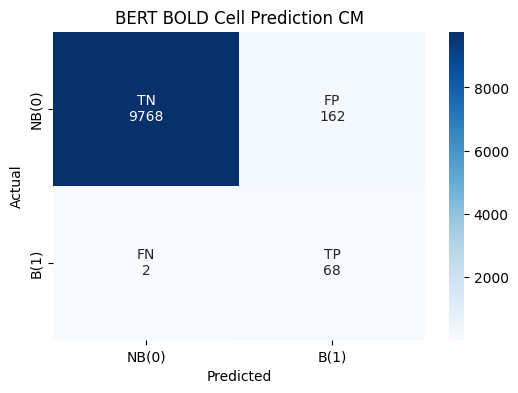


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0
6,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0
6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
from utils import inferutil
importlib.reload(inferutil)
from utils.inferutil import binfer_one

# Params
loc = 0
thresh = 0.6
cond = '>'
disp_max=True

# inference on single position of train loader params
binfer_one(
    trained_model,
    train_loader,
    loc=loc,
    threshold=thresh,
    condition=cond,
    disp_max=disp_max,
    device=DEVICE
)


Filename: ../../data/farzan/manual_val/advanced-placement-mathematics-enrollment.xlsx

--- Unique Sigmoid Probabilities for Bold Cells ---
(4,5): 0.58736199140548706055
(4,11): 0.62221252918243408203
(5,4): 0.62581676244735717773
(5,3): 0.63276749849319458008
(4,13): 0.65836364030838012695
(4,3): 0.67535936832427978516
(3,2): 0.68028301000595092773
(3,1): 0.68076086044311523438
(3,21): 0.68239319324493408203
(3,19): 0.68689382076263427734
(4,15): 0.69619351625442504883
(4,9): 0.69751894474029541016
(3,22): 0.70575040578842163086
(1,1): 0.71694868803024291992
(3,17): 0.71918386220932006836
(3,3): 0.72691118717193603516
(4,7): 0.73771578073501586914

NB to B ratio: Predicted = 9785:215 | Actual = 9937:63
Accuracy: 98.44% | Precision: 28.37% | Recall: 96.83% | F1-Score: 0.44



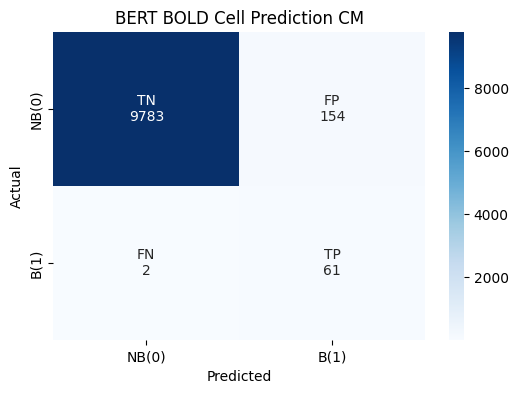


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0
6,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0


In [18]:
binfer_one(
    trained_model,
    val_loader,
    loc=loc,
    threshold=thresh,
    condition=cond,
    disp_max=disp_max,
    device=DEVICE
)

In [19]:
print('Hello')

Hello
